# Text Indexing

*Information Retrieval* is about *selecting* the documents from a - possibly large - collection that match the *query*, and *ranking* the result set according to relevance. One obvious use-case are internet search engines, but efficient and precise search is needed in many other applications.

## Selection

The first part of retrieval is finding the documents that are match the query, ignoring their relative relevance for now.

One obvious way to do this what we have already done for the secondary indexing case with the global city database. We created an *inverted index* or *inverted file*: a dictionary that records the set of documents (cities) that match a search term.

This is the similar to the index at the back of a book, which maps index terms to pages:

<img src="figures/book-index.png" alt="Index" width="400"/>

In [4]:
documents = {
    1: "a donut on a glass plate",
    2: "only the donut",
    3: "listen to the drum machine",
}

def extract_terms(document):
    for word in document.split():
        if len(word) > 2:
            yield word.lower()

def build_full_text_index(corpus):
    index = dict()
    for id, document in corpus.items():
        for term in extract_terms(document):
            index.setdefault(term, set()).add(id)
    return index

index = build_full_text_index(documents)
index

{'donut': {1, 2},
 'glass': {1},
 'plate': {1},
 'only': {2},
 'the': {2, 3},
 'listen': {3},
 'drum': {3},
 'machine': {3}}

### Querying

We can query the index using a collection of search terms. Conveniently, we use the same term extractor on the query as we used for indexing.

In [5]:
def query_index(index, query):
    result_set = None
    for term in extract_terms(query):
        results = index.get(term, set())
        result_set = results if result_set is None else result_set.intersection(results)
    return result_set

query_index(index, "the")

{2, 3}

### Term Extraction: Filtering & Expansion

We are probably not very interested in documents containing words that appear everywhere, such as `a` and `the`. Also, we'd like our index to ignore upper- and lowercase variants.

A more sophisticated term extractor would likely perform additional filtering and expansions:
  * transform words to their stems ("donuts" --> "donut")
  * add synonyms ("donut" --> "pastry")
  * add acronmys ("HTML" --> "hypertext markup language")

#### Excercise A

Add stop-wording and case filtering to the term extraction function!

## Index Wikipedia

Can we build an index of German Wikipedia in a reasonable amount of time? Lets download the abstracts of the first few 100k articles from https://dumps.wikimedia.org/dewiki/latest/dewiki-latest-abstract1.xml.gz (88MB).

Alternatively, get all of them from https://dumps.wikimedia.org/dewiki/latest/dewiki-latest-abstract.xml.gz (364MB, 2.8M articles).

In [14]:
!curl https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-abstract1.xml.gz -o data/enwiki-abstract1.xml.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  118M  100  118M    0     0  4010k      0  0:00:30  0:00:30 --:--:-- 4020k0  3392k      0  0:00:35  0:00:05  0:00:30 3777k  0     0  3794k      0  0:00:32  0:00:09  0:00:23 4581k


In [50]:
!curl https://dumps.wikimedia.org/dewiki/latest/dewiki-latest-abstract.xml.gz -o data/dewikide-abstract.xml.gz
!curl https://dumps.wikimedia.org/dewiki/latest/dewiki-latest-abstract1.xml.gz -o data/dewikide-abstract1.xml.gz


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  364M  100  364M    0     0  4310k      0  0:01:26  0:01:26 --:--:-- 4454k     0  4201k      0  0:01:28  0:00:10  0:01:18 4495k01:26  0:00:18  0:01:08 4559k:00:37  0:00:51 3712k0  0:01:29  0:00:39  0:00:50 3514k 0  0:01:29  0:00:45  0:00:44 4423k  0  0:01:27  0:01:02  0:00:25 4406k2k      0  0:01:26  0:01:17  0:00:09 4482k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 88.3M  100 88.3M    0     0  4331k      0  0:00:20  0:00:20 --:--:-- 4493k     0  0:00:23  0:00:04  0:00:19 3863k


Let's look at a few lines of the downloaded archive. On unix-like systems, this is straight-forward: `gzcat` streams a gzipped file to standard output, `head` limits the output to the first few lines.

In [1]:
!gzcat data/dewiki-abstract.xml.gz | head

<feed>
<doc>
<title>Wikipedia: Alan Smithee</title>
<url>https://de.wikipedia.org/wiki/Alan_Smithee</url>
<abstract>Alan Smithee steht als Pseudonym für einen fiktiven Regisseur, der Filme verantwortet, bei denen der eigentliche Regisseur seinen Namen nicht mit dem Werk in Verbindung gebracht haben möchte. Von 1968 bis 2000 wurde es von der Directors Guild of America (DGA) für solche Situationen empfohlen.</abstract>
<links>
<sublink linktype="nav"><anchor>Geschichte</anchor><link>https://de.wikipedia.org/wiki/Alan_Smithee#Geschichte</link></sublink>
<sublink linktype="nav"><anchor>Entstehung</anchor><link>https://de.wikipedia.org/wiki/Alan_Smithee#Entstehung</link></sublink>
<sublink linktype="nav"><anchor>Aufdeckung und Abkehr</anchor><link>https://de.wikipedia.org/wiki/Alan_Smithee#Aufdeckung_und_Abkehr</link></sublink>
<sublink linktype="nav"><anchor>Verwendung</anchor><link>https://de.wikipedia.org/wiki/Alan_Smithee#Verwendung</link></sublink>
gzcat: error writing to output: Broke

Aha, we are interested in the <abstract></abstract> element contents. Let's read those. Also, the article URL could serve as a useful identifier for each document. Below, we use a bit of Python XML magic to generate all (url, abstract) tuples in the downloaded archive. You don't need to understand the details (but you may well).

In [1]:
def read_wikipedia_abstracts(filename="dewiki-abstract1.xml"):
    """Read the given filename and yield each articles fulltext."""
    from io import TextIOWrapper
    import gzip
    from xml.dom import pulldom

    with gzip.open(f'data/{filename}.gz', mode='rt') as xml:
        doc = pulldom.parse(xml)
        url = None
        abstract = None
        for event, node in doc:
            try:
                if event == pulldom.START_ELEMENT and node.tagName == 'url':
                    doc.expandNode(node)
                    url = node.firstChild.data
                elif event == pulldom.START_ELEMENT and node.tagName == 'abstract':
                    doc.expandNode(node)
                    abstract = node.firstChild.data
                    yield url, abstract
            except AttributeError:
                # Ignore missing articles for now
                pass

next(read_wikipedia_abstracts())



('https://de.wikipedia.org/wiki/Alan_Smithee',
 'Alan Smithee steht als Pseudonym für einen fiktiven Regisseur, der Filme verantwortet, bei denen der eigentliche Regisseur seinen Namen nicht mit dem Werk in Verbindung gebracht haben möchte. Von 1968 bis 2000 wurde es von der Directors Guild of America (DGA) für solche Situationen empfohlen.')

### Excercise 2

Create an index of all wikipedia abstracts!

In [ ]:
from tqdm.auto import tqdm
def build_full_text_index(corpus, index=None):
    index = dict() if index is None else index
    for id, document in tqdm(corpus):
        for term in extract_terms(document):
            index.setdefault(term, set()).add(id)
    return index

index = build_full_text_index(read_wikipedia_abstracts("dewiki-abstract.xml"))

In [40]:
query_index(index, "zurich")

{'https://en.wikipedia.org/wiki/Battle_of_Zurich',
 'https://en.wikipedia.org/wiki/Beat_Richner',
 'https://en.wikipedia.org/wiki/Chameleon_(computing)',
 'https://en.wikipedia.org/wiki/Eduard_Schweizer',
 'https://en.wikipedia.org/wiki/Extreme_performance_art',
 'https://en.wikipedia.org/wiki/Feldbach,_Switzerland',
 'https://en.wikipedia.org/wiki/Gnomes_of_Zurich',
 'https://en.wikipedia.org/wiki/Hans_Konrad_von_Orelli',
 'https://en.wikipedia.org/wiki/IC_2000',
 'https://en.wikipedia.org/wiki/Jean_Baptiste_Marie_Franceschi-Delonne',
 'https://en.wikipedia.org/wiki/Johann_Heinrich_Hottinger',
 'https://en.wikipedia.org/wiki/Josias_Simmler',
 'https://en.wikipedia.org/wiki/Julius_Friedrich_Lehmann',
 'https://en.wikipedia.org/wiki/Kehlhof',
 'https://en.wikipedia.org/wiki/Pilatus_SB-2',
 'https://en.wikipedia.org/wiki/Richard_Avenarius',
 'https://en.wikipedia.org/wiki/Saint_Lucia_Football_Association',
 'https://en.wikipedia.org/wiki/Saint_Vincent_and_the_Grenadines_Football_Federati

## Ranking

We really care about which document is the best match for a query. We also want to avoid dropping a good search result simply because one minor search term does not appear in it. Let's rephrase search to include all documents that contain any of the search terms (instead of all of them):

In [5]:
def query_index2(index, query):
    result_set = None
    for term in extract_terms(query):
        results = index.get(term, set())
        result_set = results if result_set is None else result_set.union(results)
    return result_set


Oh, and to illustrate, we are going to use a dataset including all German wikipedia articles (not just summaries) about:
  * Movies of 1985 (`data/movies_1985.csv.zip`)
  * Movies of the 1970ies (`data/movies_197x.csv.zip`)
  * Movies of the 1980ies (`data/movies_198x.csv.zip`)
  * Movies of the 1990ies (`data/movies_199x.csv.zip`)

The CSVs have two columns: the wikipedia url as identifier, and the full article as text.

Let's code a generator that reads the (unzipped) CSV and yields each tuple:

In [7]:
def read_movie_csv(filename):
    import csv
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        for url, text in reader:
            yield url, text

In [8]:
movie_index = build_full_text_index(read_movie_csv('data/movies_1985.csv'))

0it [00:00, ?it/s]

### Querying with Union

While a specific query such as `delorean` works fine, query terms that appear frequently are blow up the search results:

In [9]:
query_index(movie_index, "michael fox delorean")

{'https://de.wikipedia.org/wiki/Zur%C3%BCck_in_die_Zukunft_(Film)'}

Which terms are interesting? Clearly, a term that appears in all or most documents is quite uninteresting. Let's find out in how many docs each term appears.

In [10]:
import math
terms_sorted = dict(sorted({term: len(ids) for term, ids in movie_index.items()}.items(), key=lambda item: item[1], reverse=True))
terms_sorted

{'der': 387,
 'ist': 387,
 'die': 386,
 'und': 385,
 'von': 383,
 'weblinks': 383,
 'ein': 379,
 'dem': 378,
 'internet': 372,
 'movie': 372,
 'database': 372,
 '(englisch)': 371,
 'den': 370,
 'mit': 366,
 'sich': 364,
 'aus': 363,
 'auf': 363,
 'handlung': 362,
 'als': 356,
 'eine': 354,
 'das': 354,
 'des': 349,
 'film': 345,
 'bei': 339,
 'einzelnachweise': 336,
 'für': 331,
 'sie': 321,
 'einem': 310,
 'auch': 308,
 'nicht': 307,
 'wurde': 307,
 'einer': 306,
 'jahr': 305,
 'nach': 304,
 'dass': 301,
 'wird': 298,
 'einen': 294,
 'seine': 269,
 '1985': 261,
 'seiner': 236,
 '1985.': 235,
 'zum': 234,
 'aber': 227,
 'durch': 224,
 'wie': 220,
 'vor': 220,
 'ihn': 218,
 'unter': 218,
 'ihm': 217,
 'über': 210,
 'noch': 207,
 'nur': 206,
 'sein': 205,
 'eines': 204,
 'jedoch': 202,
 'hat': 202,
 'während': 199,
 'war': 199,
 'ihr': 197,
 'dieser': 192,
 'films': 192,
 'zur': 188,
 'werden': 187,
 'seinen': 186,
 'vom': 185,
 'ihre': 183,
 'seinem': 183,
 'doch': 182,
 'wieder': 182,


 Normalizing by the number of documents gives us a value that is agnostic of the corpus size:

In [11]:
max_weight = next(iter(terms_sorted.items()))[1]
terms_sorted = {term: weight/max_weight for term, weight in terms_sorted.items()}
terms_sorted

{'der': 1.0,
 'ist': 1.0,
 'die': 0.9974160206718347,
 'und': 0.9948320413436692,
 'von': 0.9896640826873385,
 'weblinks': 0.9896640826873385,
 'ein': 0.979328165374677,
 'dem': 0.9767441860465116,
 'internet': 0.9612403100775194,
 'movie': 0.9612403100775194,
 'database': 0.9612403100775194,
 '(englisch)': 0.958656330749354,
 'den': 0.9560723514211886,
 'mit': 0.9457364341085271,
 'sich': 0.9405684754521964,
 'aus': 0.937984496124031,
 'auf': 0.937984496124031,
 'handlung': 0.9354005167958657,
 'als': 0.9198966408268734,
 'eine': 0.9147286821705426,
 'das': 0.9147286821705426,
 'des': 0.9018087855297158,
 'film': 0.8914728682170543,
 'bei': 0.875968992248062,
 'einzelnachweise': 0.8682170542635659,
 'für': 0.8552971576227391,
 'sie': 0.8294573643410853,
 'einem': 0.8010335917312662,
 'auch': 0.7958656330749354,
 'nicht': 0.7932816537467701,
 'wurde': 0.7932816537467701,
 'einer': 0.7906976744186046,
 'jahr': 0.7881136950904393,
 'nach': 0.7855297157622739,
 'dass': 0.7777777777777778,

Clearly, we could use the head (or tail) of that list to automate stopwording - we don't want any terms in the index that appear everywhere.

So, the term `michael` appears in roughly 11% of the docs, while `fox` only appears in 1.3%:

In [12]:
print(f"Michael: {terms_sorted['michael']:.2g}, Fox: {terms_sorted['fox']:.2g}, Delorean: {terms_sorted['delorean']:.2g}")

Michael: 0.15, Fox: 0.016, Delorean: 0.0026


### Visualize term frequencies

If we are to use the term frequency to compute an overall rank of the search results, it would be nice if we could somehow add up the contributions of each term. For this, it is important to know the shape of the term frequencies.

Let's plot them:

['der', 'billboard', 'critics.', 'mörderin,', 'bockelmann', 'karte', 'stadtbewohner', 'schaufelraddampfer', 'stelze', 'phoenix)', 'moni,']


/var/folders/rs/4ym7352x37df592tnnlbw2mm0000gn/T/ipykernel_79420/1604194707.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([None] + labels[0:-1:label_multiple], rotation=90)


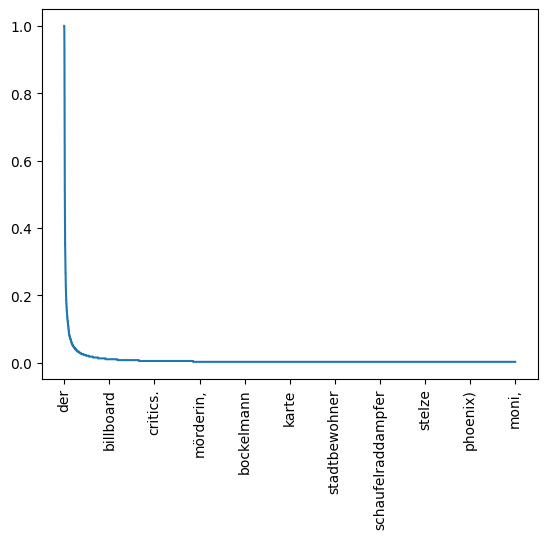

In [20]:
#!pip install matplotlib

def plot_terms(terms):
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import math

    labels = [x for x, y in terms.items()]
    values = [y for x, y in terms.items()]
    fig, ax = plt.subplots() 
    #ax.set_yscale('log')
    label_count = 10
    label_multiple = len(terms) // label_count
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(label_multiple, 0))
    ax.set_xticklabels([None] + labels[0:-1:label_multiple], rotation=90)
    print(labels[0:-1:label_multiple])
    ax.plot(values)

plot_terms(terms_sorted)

Hm, this surely looks like a [power law distribution](https://en.wikipedia.org/wiki/Power_law). Indeed, [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law) states that the most common word appears roughly twice as often as the next common one.

Applying a log to the (inverted) frequency would probably help with making the value useful for ranking:

Michael: -1.9, Fox: -4.2, delorean: -6
['der', 'billboard', 'critics.', 'mörderin,', 'bockelmann', 'karte', 'stadtbewohner', 'schaufelraddampfer', 'stelze', 'phoenix)', 'moni,']


/var/folders/rs/4ym7352x37df592tnnlbw2mm0000gn/T/ipykernel_79420/1604194707.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([None] + labels[0:-1:label_multiple], rotation=90)


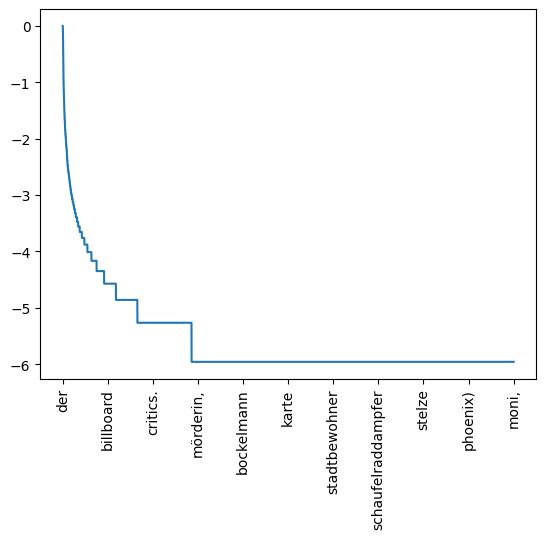

In [21]:
import math
log_terms = {term: math.log(weight) for term, weight in terms_sorted.items()}
print(f"Michael: {log_terms['michael']:.2g}, Fox: {log_terms['fox']:.2g}, delorean: {log_terms['delorean']:.2g}")

plot_terms(log_terms)

### Ranking: Putting things together
Let's rank the search results by summing up the IDF values for each search term:

In [15]:
def query_index_weighted(index, query):
    result_set = dict()
    for term in extract_terms(query):
        idf = log_terms[term]
        results = index.get(term, set())
        for result in results:
            result_set[result] = result_set.get(result, 0) + idf
    return dict(sorted(result_set.items(), key=lambda item: item[1]))

Ah, now _Back to the Future_ at last appears in the top search results:

In [18]:
query_index_weighted(movie_index, "michael fox delorean")

{'https://de.wikipedia.org/wiki/Zur%C3%BCck_in_die_Zukunft_(Film)': -12.04046334202674,
 'https://de.wikipedia.org/wiki/Zur%C3%BCck_in_die_Zukunft_II': -12.04046334202674,
 'https://de.wikipedia.org/wiki/James_Bond_007_%E2%80%93_Im_Angesicht_des_Todes': -6.082038648996958,
 'https://de.wikipedia.org/wiki/Die_letzten_Tage_in_Kenya': -6.082038648996958,
 'https://de.wikipedia.org/wiki/Let_It_Be_(Film)': -6.082038648996958,
 'https://de.wikipedia.org/wiki/Midnight_Madness_(Film)': -6.082038648996958,
 'https://de.wikipedia.org/wiki/Columbo:_Traumschiff_des_Todes': -6.082038648996958,
 'https://de.wikipedia.org/wiki/James_Bond_007_%E2%80%93_Der_Hauch_des_Todes': -6.082038648996958,
 'https://de.wikipedia.org/wiki/Megaforce_(Film)': -6.082038648996958,
 'https://de.wikipedia.org/wiki/Die_R%C3%BCckkehr_der_Killertomaten': -6.082038648996958,
 'https://de.wikipedia.org/wiki/Alarmstufe_1_(1985)': -6.082038648996958,
 'https://de.wikipedia.org/wiki/Scavenger_Hunt_(Film)': -6.082038648996958,
 '

In [17]:
movie_index = build_full_text_index(read_movie_csv('data/movies_197x.csv'))
movie_index = build_full_text_index(read_movie_csv('data/movies_198x.csv'), movie_index)

0it [00:00, ?it/s]

0it [00:00, ?it/s]